# Multioutput Gaussian Process test 1, applied to Mocap data-set

Some previous definitions and library invocations needed to process data

In [326]:
%pylab inline
import numpy as np
import pylab as pb
import GPy
import urllib


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Fisrt is necesary to retrieve the data from the mocap database located at: http://mocap.cs.cmu.edu/, there one can encounter different datasets of human motion on different situations. There are several files describing the motion of an skeleton, for the purpose of this implementation one can use the .amc files, which specifies the angle of each joint defined by the skeleton for an specific time stamp or frame. The following code retrieves the data of an specific movement previously defined by the user, for that objective first one have to identify the desired motion in this case, a soccer player kicking a ball: http://mocap.cs.cmu.edu/search.php?subjectnumber=10&trinum=6

Then is necesary to copy the link of the amc file located in that page, for this case: mocap.cs.cmu.edu/subjects/10/10_06.amc, then it's only replacing it in the value of the url variable like this:

In [327]:
url = ("http://mocap.cs.cmu.edu/subjects/10/10_06.amc") # Tell to python where is the file
urllib.urlretrieve(url, '10_06.amc') # Tell python to retrieve the file

('10_06.amc', <httplib.HTTPMessage instance at 0x7f62199b45a8>)

The file will be downloaded in the same dir where your code or notebook is located, the next code parses the file and extract all the information related with the angles of the joints on each frame, and stores that information in the variable X.

In [328]:
amc_file = open('10_06.amc', 'r')
cont = 0
read_frames = False
print 'Reading header...'
frame = 1
bone = 0
bone_map_dof = {}
bone_name = {}
all_samples = {}
samples_frame = 0
for mline in amc_file:
	if(mline == ":DEGREES\r\n" and read_frames == False):
	    read_frames = True
	    print 'now reading frames'
	    continue
	elif(read_frames):
	    params = mline.split(' ')
	    if params[0] == str(frame) + '\r\n':
	    	#print 'reading frame: ' + str(frame)
	    	if(frame >= 2):
	    		#print samples_frame
	    		all_samples[frame - 1] = samples_frame

	    	samples_frame = 0
	        frame += 1
	        bone = 1
	    else:
	    	if(bone == 1):
	    		samples_frame = np.array(params[1:len(params)], dtype=float)
	    		#print samples_frame
	    		bone_map_dof[bone] = len(params) - 1
	    		bone_name[bone] = params[0]
	    	else:        		
	        	bone_sample = np.array(params[1:len(params)], dtype=float)
	        	samples_frame = np.append(samples_frame, bone_sample)
	        	bone_map_dof[bone] = len(params) - 1
	        	bone_name[bone] = params[0]
	        bone += 1
all_samples[frame - 1] = samples_frame
#print all_samples[1], bone_map, bone_name
X = np.zeros((all_samples[1].shape[0], len(all_samples)))
for i in range(0,len(all_samples)):
	X[:,i] = all_samples[i + 1]
print 'File succesfully loaded'

Reading header...
now reading frames
File succesfully loaded


The variable X is a numpy array like which its rows corresponds to all the time samples of one angle of each joint. The skeleton is defined to give each joint several degrees of freedom depending on the motion constraints, lets check some one of the samples in a graph:

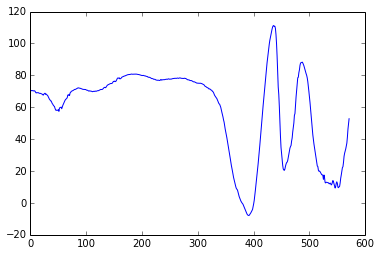

In [329]:
time_stamps = np.arange(len(all_samples))
pb.plot(time_stamps, X[40,:])
#print len(bone_map)

## Example of one output GP with some joint signal

<function matplotlib.pyplot.colorbar>

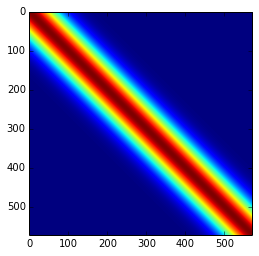

In [330]:
d = 1          # input dimension
var = 10.       # variance
theta = 50.0 
k = GPy.kern.RBF(d, variance=var, lengthscale=theta)
input_t = time_stamps
input_t = input_t[:,None]
Y = X[40,:]
Y = Y[:, None]
#input_t = np.matrix(time_stamps)
#input_t = np.transpose(input_t)
C = k.K(input_t)
plt.imshow(C)
plt.colorbar
#print time_stamps, input_t

In [331]:
m = GPy.models.GPRegression(input_t,Y,k)
print m


Name                 : GP regression
Log-likelihood       : -51095.7788102
Number of Parameters : 3
Parameters:
  GP_regression.           |  Value  |  Constraint  |  Prior  |  Tied to
  rbf.variance             |   10.0  |     +ve      |         |         
  rbf.lengthscale          |   50.0  |     +ve      |         |         
  Gaussian_noise.variance  |    1.0  |     +ve      |         |         


{'dataplot': [<matplotlib.lines.Line2D at 0x7f6219b66a10>],
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f6219a646d0>],
  [<matplotlib.lines.Line2D at 0x7f621995c490>]]}

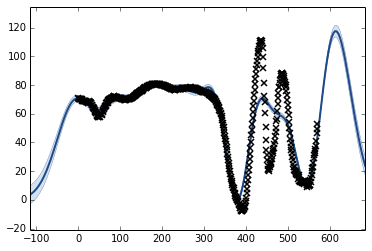

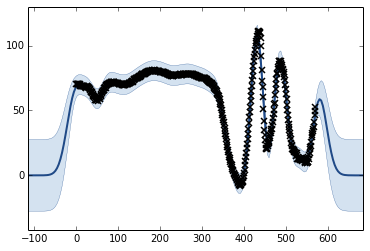

In [332]:
m.plot()
m.optimize()
m.plot()

# Multioutput Gaussian Processes

In this section we will try to make multioutput regression using all the outputs of the mocap database , first the covariance matrix will be calculated, then it will be used to make some samples of each for some of the outputs loaded before, some of the points in some of the outputs will be ommited and it will be evaluated the accuracy of the prediction made by the process on those outputs which some of its data points were omitted.

62


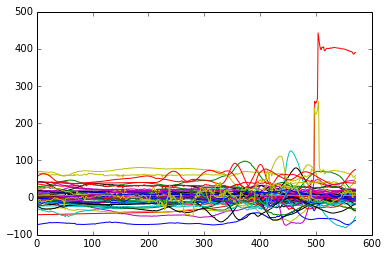

In [333]:
print X.shape[0]
for i in range(0,X.shape[0]):
    # extract the event 
    x_event = time_stamps
    y_event = X[i,:]
    pb.plot(x_event, y_event)
    

The graph above represents all the outputs of the motion of the body for a ceratin sequence. Next it's neccesary to accomodate the input variable(time) as one column vector and the id's of the outputs also in the same way to use the covariance function and the coregionalization matrix respectively.

In [334]:
def GPTest(X, input_t, n_signals=5):
    #sup_input = time_stamps
    sup_input = input_t[:,0]
    sup_input_id = np.zeros(input_t.shape[0])
    sup_output = X[0,:]
    tmp_output = sup_output
    tmp_input = sup_input
    for i in range(1,n_signals):
        tmp_input = np.append(tmp_input, sup_input)
        tmp_input_id = np.linspace(i,i,X.shape[1])
        sup_input_id = np.append(sup_input_id, tmp_input_id)
        tmp_output = np.append(tmp_output, X[i,:])

    sup_input = tmp_input
    #sup_input = sup_input*(1/100.0)
    sup_output = tmp_output
    sup_output = sup_output[:,None]
    all_X = np.vstack((sup_input, sup_input_id))
    all_X = np.transpose(all_X)
    #print all_X[:,0]
    #print all_X[:,1]
    print all_X.shape, sup_output.shape
    # Defining the covariance and the coregionalization matrix, first one can try with an RBF
    kern = GPy.kern.RBF(1., lengthscale=50.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=X.shape[0], rank=n_signals-1)
    model = GPy.models.GPRegression(all_X, sup_output, kern)
    return model, all_X, sup_output

## Making 'predictions' with all the dataset

In [335]:
print X.shape, time_stamps.shape, input_t.shape
#print X, input_t
model, sup_input, sup_output = GPTest(X, input_t)

(62, 572) (572,) (572, 1)
(2860, 2) (2860, 1)


[[   0.    0.]
 [   1.    0.]
 [   2.    0.]
 ..., 
 [ 569.    4.]
 [ 570.    4.]
 [ 571.    4.]]
2.1799394318


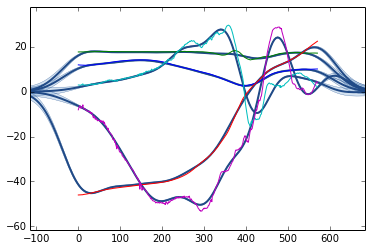

In [336]:
for i in range(5):
    model.plot(fignum=1,fixed_inputs=[(1, i)], plot_raw=True)

for i in range(0,5):
    # extract the event 
    x_event = time_stamps
    y_event = X[i,:]
    pb.plot(x_event, y_event)

print sup_input
mu, var = model._raw_predict(sup_input)
mean_sq_err = mu - sup_output
mean_sq_err = np.power(mean_sq_err, 2)
val_mean_sq_err = np.sum(mean_sq_err) / mean_sq_err.shape[0]
print val_mean_sq_err

## Denying some inputs to the process and predicting in that way

In [337]:
n_frames = time_stamps.shape[0]
n_outputs = 5
index = np.random.permutation(n_frames)
Ntest = 400
input_t = index[Ntest:X.shape[1]]
input_t = input_t[:,None]
input_test = index[0:Ntest]
input_test = input_test[:,None]

Y_train = np.zeros((X.shape[0], X.shape[1] - Ntest))
Y_test = np.zeros((X.shape[0], Ntest))
for i in range(0,X.shape[0]):
    Y_train[i,:] = X[i,index[Ntest:X.shape[1]]]
    Y_test[i,:] = X[i,index[0:Ntest]]

sup_input_test = input_test
sup_input_id = np.zeros(sup_input_test.shape[0])
tmp_input = sup_input_test
for i in range(1,n_signals):
        tmp_input = np.append(tmp_input, sup_input_test)
        tmp_input_id = np.linspace(i,i,Ntest)
        sup_input_id = np.append(sup_input_id, tmp_input_id)

sup_input_test = tmp_input
X_test = np.vstack((sup_input_test, sup_input_id))
X_test = X_test.transpose()
#print X_test
model, sup_input, sup_output = GPTest(Y_train, input_t, n_outputs)
#print sup_input
#print X_test.shape, X_train.shape

(860, 2) (860, 1)


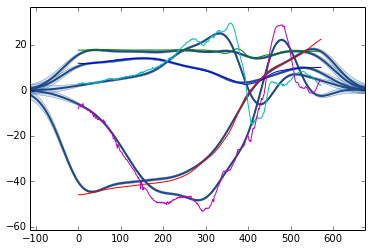

In [338]:
for i in range(5):
    model.plot(fignum=1,fixed_inputs=[(1, i)],plot_raw=True)
for i in range(0,5):
    # extract the event 
    x_event = time_stamps
    y_event = X[i,:]
    pb.plot(x_event, y_event)

In [341]:
#model.predict(X_test[0:5,:])
mu, var = model._raw_predict(X_test)